In [ ]:
import os, shutil
shutil.copy(os.path.join('../input/convnext-roberta-final-v1-20epochs/convnextroberta20.pt'), os.path.join('/kaggle/working/'))

'/kaggle/working/convnextroberta20.pt'

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.8/512.8 kB 1.4 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [ ]:
class CFG:
    debug = False
    image_path = "../input/flickr-image-dataset/flickr30k_images/flickr30k_images"
    captions_path = "."
    batch_size = 32
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-5
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 5
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #model_name = 'vit_base_patch32_224_in21k'
    model_name = 'convnext_base_in22ft1k'
    image_embedding = 1024
    text_encoder_model = "roberta-base"
    text_embedding = 768
    text_tokenizer = "roberta-base"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256 
    dropout = 0.1

## Image Encoder

In [ ]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0,
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

## Text Encoder

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = RobertaModel.from_pretrained(model_name)
        else:
            self.model = RobertaModel(config=RobertaConfig())
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

## Projection Head

In [ ]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

## CLIP

In [ ]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [ ]:
def get_model(model_path):
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    return model
model = get_model("convnextroberta20.pt")
print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_base_22k_1k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_base_22k_1k_224.pth


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model parameters: 212,803,968


In [ ]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image

preprocess = Compose([
    Resize(CFG.size, interpolation=Image.BICUBIC),
    CenterCrop(CFG.size),
    ToTensor()
])

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 264MiB/s]


#  ****EXEMPLE 1****
# 

In [ ]:
# Dashcam video of driving around San Francisco
video_url = "https://www.youtube.com/watch?v=F6KSLsj1Lr0"  

# How much frames to skip
N = 120

In [ ]:
# pytube is used to download videos from YouTube
!pip install pytube

# Intall a newer version of plotly
!pip install plotly==4.14.3

# Install torch 1.7.1 with GPU support
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 395.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 24.8 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.8.2
    Uninstalling plotly-5.8.2:
      Successfully uninstalled plotly-5.8.2
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 735.4/735.4 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 19.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0
    Uninstalling torchvision-0.12.0:
      Successfully uninstalled torchvision-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the 

In [ ]:
from pytube import YouTube

# Choose a video stream with resolution of 360p
streams = YouTube(video_url).streams.filter(adaptive=True, subtype="mp4", resolution="360p", only_video=True)

# Check if there is a valid stream
if len(streams) == 0:
    
    raise "No suitable stream found for this YouTube video!"

# Download the video as video.mp4
print("Downloading...")
streams[0].download(filename="video.mp4")
print("Download completed.")

Downloading...
Download completed.


In [ ]:
import cv2
from PIL import Image

# The frame images will be stored in video_frames
video_frames = []

# Open the video file
capture = cv2.VideoCapture('video.mp4')
fps = capture.get(cv2.CAP_PROP_FPS)

current_frame = 0
while capture.isOpened():
    
  # Read the current frame
    ret, frame = capture.read()
  # Convert it to a PIL image (required for CLIP) and store it
    if ret == True:
        
        video_frames.append(Image.fromarray(frame[:, :, ::-1]))
    else:
        break

  # Skip N frames
    current_frame += N
    capture.set(cv2.CAP_PROP_POS_FRAMES, current_frame)

# Print some statistics
print(f"Frames extracted: {len(video_frames)}")

Frames extracted: 960


In [ ]:
import math
import numpy as np
import torch

# You can try tuning the batch size for very large videos, but it should usually be OK
batch_size = 256
batches = math.ceil(len(video_frames) / batch_size)

# The encoded features will bs stored in video_features
video_features = torch.empty([0, CFG.projection_dim], dtype=torch.float16).to(device)

# Process each batch
for i in range(batches):
    print(f"Processing batch {i+1}/{batches}")

  # Get the relevant frames
    batch_frames = video_frames[i*batch_size : (i+1)*batch_size]
  
  # Preprocess the images for the batch
    batch_preprocessed = torch.stack([preprocess(frame) for frame in batch_frames]).to(device)
  
  # Encode with CLIP and normalize
    with torch.no_grad():
        batch_features = model.image_encoder(batch_preprocessed.to(CFG.device))
        batch_features = model.image_projection(batch_features)
        batch_features = F.normalize(batch_features, p=2, dim=-1)

  # Append the batch to the list containing all features
    video_features = torch.cat((video_features, batch_features))

# Print some stats
print(f"Features: {video_features.shape}")

Processing batch 1/4
Processing batch 2/4
Processing batch 3/4
Processing batch 4/4
Features: torch.Size([960, 256])


In [ ]:
import plotly.express as px
import datetime
from IPython.core.display import HTML

def search_video(search_query, display_heatmap=True, display_results_count=2):
    
    tokenizer = RobertaTokenizer.from_pretrained(CFG.text_tokenizer)
    query_text = encoded_query = tokenizer([search_query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in query_text.items()
        }
  # Encode and normalize the search query using CLIP
    with torch.no_grad():
        
        text_features =  model.text_encoder( 
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"] )
        text_embeddings = model.text_projection(text_features)
        text_features = F.normalize(text_embeddings, p=2, dim=-1)
        
  # Compute the similarity between the search query and each frame using the Cosine similarity
    similarities = (100.0 * video_features @ text_features.T)
    values, best_photo_idx = similarities.topk(display_results_count, dim=0)

  # Display the heatmap
    if display_heatmap:
        
        print("Search query heatmap over the frames of the video:")
        fig = px.imshow(similarities.T.cpu().numpy(), height=50, aspect='auto', color_continuous_scale='viridis')
        fig.update_layout(coloraxis_showscale=False)
        fig.update_xaxes(showticklabels=False)
        fig.update_yaxes(showticklabels=False)
        fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
        fig.show()
        print()

  # Display the top 3 frames
    for frame_id in best_photo_idx:
        display(video_frames[frame_id])

    # Find the timestamp in the video and display it
        seconds = round(frame_id.cpu().numpy()[0] * N / fps)
        display(HTML(f"Found at {str(datetime.timedelta(seconds=seconds))} (<a target=\"_blank\" href=\"{video_url}&t={seconds}\">link</a>)"))

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Search query heatmap over the frames of the video:


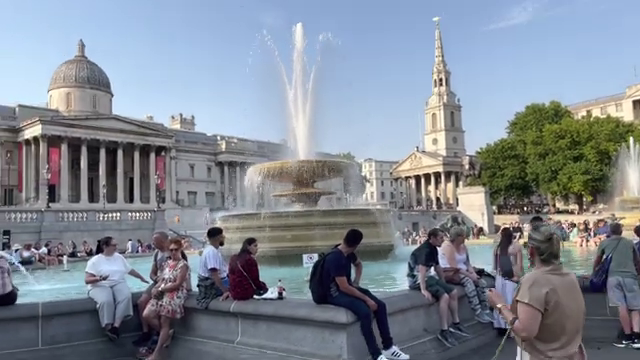

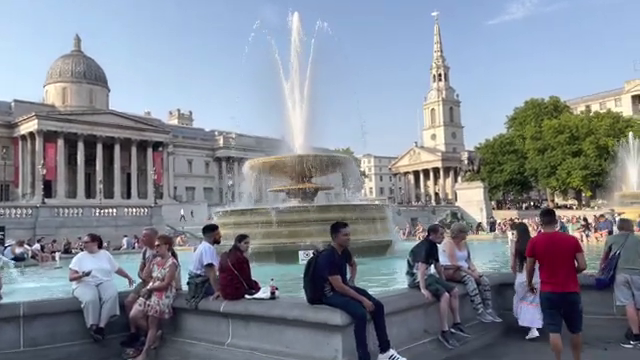

In [ ]:
search_video("Water fountain with people sitting around")

Search query heatmap over the frames of the video:


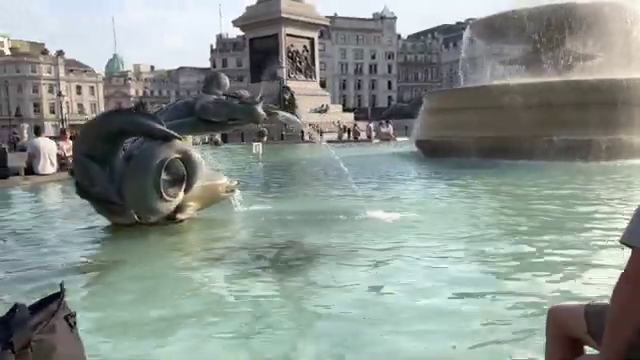

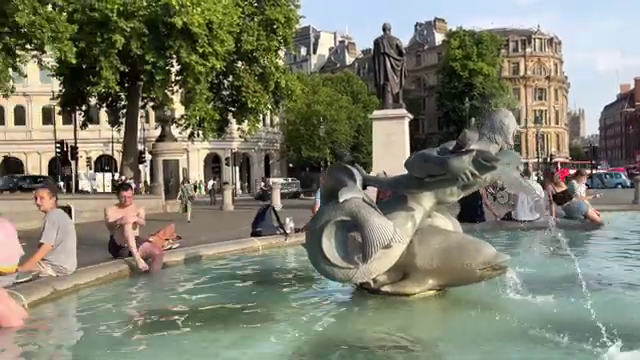

In [ ]:
search_video("a small statue in the middle of a water fountain")

Search query heatmap over the frames of the video:


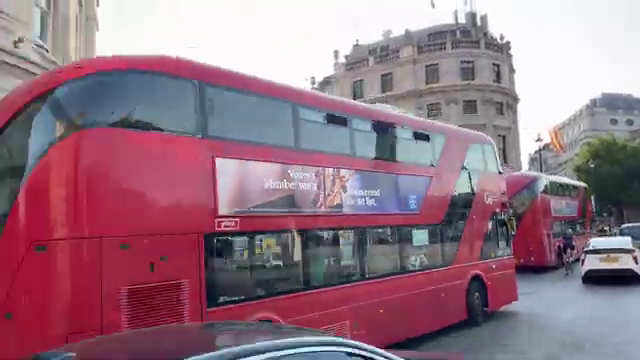

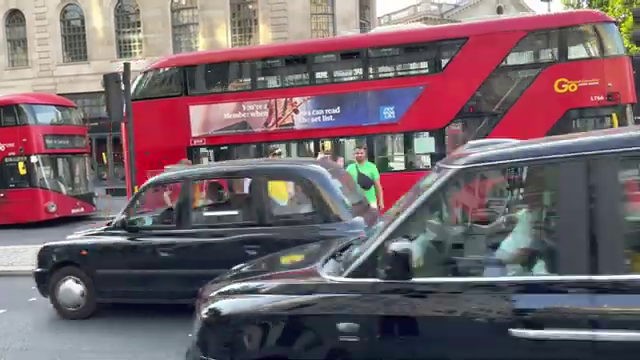

In [ ]:
search_video("Red bus")

Search query heatmap over the frames of the video:


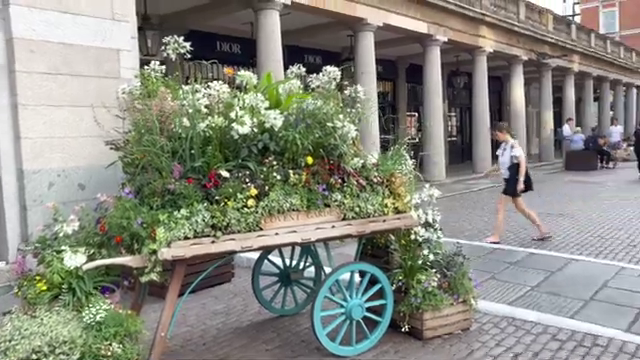

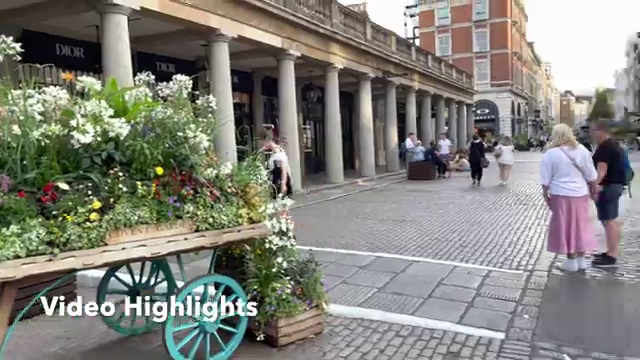

In [ ]:
search_video("Downtown flower cart")

Search query heatmap over the frames of the video:


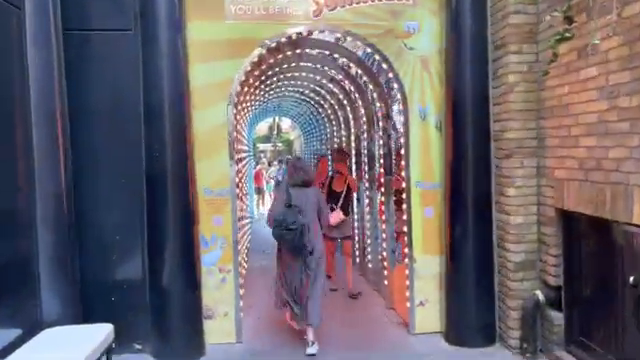

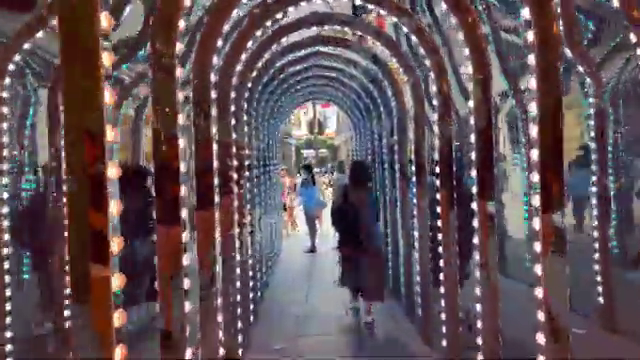

In [ ]:
search_video("People walking in a lighted tunnel")

## Final words